In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Machine Learning Handson -- Training a Neural Net

In [2]:
X = pd.read_csv("data/Xtrain.txt", sep=" ", header=None).as_matrix().reshape((-1, 24, 24))
y = pd.read_csv("data/Ytrain.txt", sep=" ", header=None).as_matrix()

Xtest = pd.read_csv("data/Xtest.txt", sep=" ", header=None).as_matrix().reshape((-1, 24, 24))
ytest = pd.read_csv("data/Ytest.txt", sep=" ", header=None).as_matrix()

Xval2 = pd.read_csv("data/Xval2.txt", sep=" ", header=None).as_matrix().reshape((-1, 24, 24))
yval2 = pd.read_csv("data/Yval2.txt", sep=" ", header=None).as_matrix()

mask = np.random.uniform(0,1,size=len(X))
mask = mask > mask.mean()

Xt = X[mask]
yt = y[mask]
Xv = X[~mask]
yv = y[~mask]

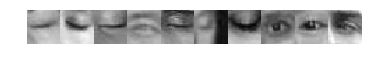

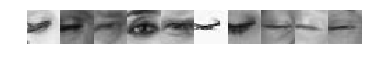

In [3]:
plt.imshow(np.concatenate(Xt[:10], axis=1), cmap="gray")
plt.axis('off')
plt.show()
plt.imshow(np.concatenate(Xval2[:10], axis=1), cmap="gray")
plt.axis('off')
plt.show()

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from PIL import Image

class EyeDataset(torch.utils.data.Dataset):
    
    def __init__(self, X, y):
        
        super(EyeDataset, self).__init__()
        
        self.X = X - X.mean()
        self.y = (y > 0) + 0
        
        assert len(self.X) == len(self.y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        
        return torch.from_numpy(self.X[index,np.newaxis]).float(), torch.from_numpy(self.y[index]).float()

In [5]:
class EyeNet(nn.Module):
    
    def __init__(self):
        
        super(EyeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=0)
        
        self.linear = nn.Linear(in_features=8*6*6, out_features=1)
        
        self.relu  = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        """ Compute the logit value """
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = x.view(-1,8*6*6)
        x = self.linear(x)
        
        return x
    
    def predict(self, x):
        
        """ Compute the probability """
        x = self.forward(x)
        x = self.sigmoid(x)
        
        return x
        
        
model = EyeNet()
model(torch.Tensor(10,1,24,24)).size()

torch.Size([10, 1])

In [6]:
data_train        = EyeDataset(Xt, yt)
data_val          = EyeDataset(Xv, yv)
data_loader_train = DataLoader(data_train, batch_size=32, shuffle=True, drop_last=True)
data_loader_val   = DataLoader(data_val, batch_size=32, shuffle=False, drop_last=True)

model = EyeNet()
bce   = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(params=model.parameters(), lr=3e-4)

train_loss = []
val_loss   = []
train_acc  = []
val_acc    = []

In [7]:
log_string = 'Epoch {}. Train Loss {:.3f} / Acc {:.3f} Val Loss {:.3f} / Acc {:.3f}'
mean = lambda x,n : np.array(x)[-n:].mean()

for n_epoch in range(300):
    model.train()
    for x, y in data_loader_train:
        y_   = model(x)
        loss = bce(y_, y)
        acc  = torch.eq((y_ > 0).float(), y).float().mean()

        optim.zero_grad()
        loss.backward()
        optim.step()

        train_loss.append(float(loss.data))
        train_acc.append(float(acc.data))
        
    model.eval()
    for x, y in data_loader_val:
        y_   = model(x)
        loss = bce(y_, y)
        acc  = torch.eq((y_ > 0).float(), y).float().mean()
        
        val_loss.append(float(loss.data))
        val_acc.append(float(acc.data))
        
    print(log_string.format(
        n_epoch,
        mean(train_loss, 10),
        mean(train_acc, 10),
        mean(val_loss, 10),
        mean(val_acc, 10),
        ), end='\r')

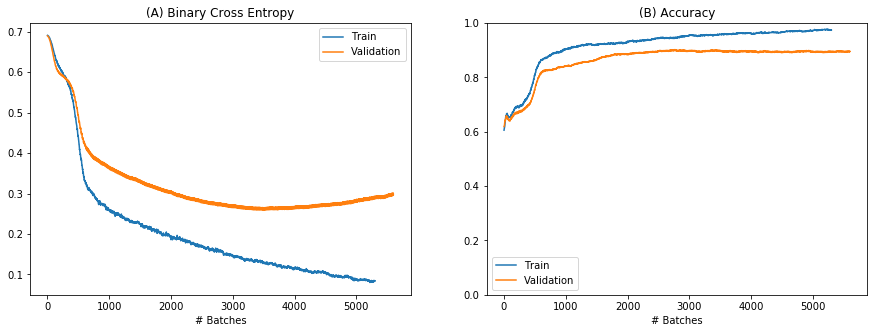

In [8]:
filter_plot = lambda x, n : np.convolve(x, np.ones(n)/n)[n:-n]

fig, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].set_title("(A) Binary Cross Entropy")
axes[0].plot(filter_plot(train_loss, 100), label='Train')
axes[0].plot(filter_plot(val_loss, 100), label='Validation')

axes[1].set_title("(B) Accuracy")
axes[1].plot(filter_plot(train_acc, 100), label='Train')
axes[1].plot(filter_plot(val_acc, 100), label='Validation')
axes[1].set_ylim([0,1])

for ax in axes:
    ax.legend()
    ax.set_xlabel('# Batches')

plt.show()

In [9]:
def evaluate(model, X, y):

    data     = EyeDataset(X, y)
    loader   = DataLoader(data, batch_size=len(X), shuffle=False, drop_last=False)

    model.eval()
    for x, y in loader:
        y_ = (model.forward(x) > 0).float()

    return y_.detach().numpy(), y.detach().numpy()

print('Accuracies\n----------')

titles = ['Train', 'Valid', 'Test', 'Right']
data   = [(Xt, yt), (Xv, yv), (Xtest, ytest), (Xval2, yval2)]

for t,(x,y) in zip(titles, data):
    y_, y = evaluate(model, x, y)
    acc = np.equal(y_, y).mean()
    
    print('{} \t {:.2f} % correct'.format(t, acc*100))

Accuracies
----------
Train 	 98.01 % correct
Valid 	 89.20 % correct
Test 	 89.59 % correct
Right 	 77.92 % correct
